# Logistic regression
Logistic regression is a powerful tool for binary classification. Given two categories of items--like Duplo- vs City-theme LEGO sets--logistic regression will predict a probability of a given item falling into either of the categories. Logistic regression makes this prediction based on the given item's properties, like weight and height. Logistic regression differs from the Perceptron because the Perceptron makes a strict binary decision about an item's classification, whereas logistic regression predicts a 0-through-1 probability of the item's classification. A probabilistic classification is advantageous when the items are not separable.

## Data processing
We again use the `Brickset-Most-Owned-Query-33-02042023.csv` introduced in `Perceptron.ipynb`. We will use logistic regression to predict a LEGO set's classification as either a Duplo- or a City-theme set based on a single explanatory variable, the number of pieces.

As mentioned before, true machine learning requires our data to be partitioned in to training, testing, and validation data, but we will again use our entire dataset as training data so we can focus on illustrating logistic regression.

In [1]:
from ipynb.fs.defs.Neuron import SingleNeuron
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Read in dataset and keep relevant columns/rows
df = pd.read_csv('data/Brickset-Most-Owned-Query-33-02042023.csv')
df = df[(df["Theme"] == "Duplo") | (df["Theme"] == "City")]
df = df.dropna()

# Assign 1 indicator for Duplo and 0 indicator for City
df["Indicator"] = np.where(df["Theme"] == "Duplo", 1, 0)

# Print out some properties of the dataframe
n_sample = len(df.index)
print("There are ", n_sample, " observations.")
print("There are ", np.sum(df["Theme"] == "Duplo"), " Duplo sets.")
print("There are ", np.sum(df["Theme"] == "City"), " City sets.")

# Create training data
X_train = df.filter(["Pieces"]).values.reshape(-1, 1)
y_train = df.filter(["Indicator"]).values.reshape(-1, 1)

duplo_ind = df["Theme"] == "Duplo"
city_ind = df["Theme"] == "City"

There are  155  observations.
There are  29  Duplo sets.
There are  126  City sets.


## Logistic regression algorithm
Once again, we will implement the `SingleNeuron` class from `Neuron.ipynb`. Let $m$ be the number of explanatory variables; in this case $m=1$ because the number of pieces is our only explanantory variable. Let $w \in \mathbb{R}^m$ represent the neuron weights and $b \in \mathbb{R}$ represent the neuron bias. For data point $i$ with input signal $x \in \mathbb{R}^m$ and response value (weight) $y^i \in \mathbb{R}$, the preactivation value is $z^i = w \cdot x^i + b$.

The activation function is the sigmoid function: $\hat y^i = \phi(z^i) = \frac{1}{1 + \exp(-z^i)}$. The sigmoid function is a differentiable S-shaped curve with range 0 to 1.

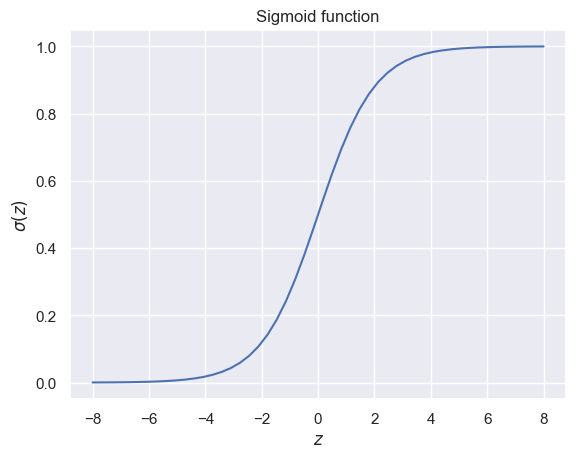

In [2]:
def sigmoid(z):
    '''
    RETURNS 1 / (1 + exp(-z))
    '''
    return 1 / (1 + np.exp(-z))

xdom = np.linspace(-8, 8, 50)
sns.set_theme()
plt.plot(xdom, sigmoid(xdom))
plt.title("Sigmoid function")
plt.xlabel("$z$")
plt.ylabel("$\sigma(z)$")
plt.show()

For a data point $i$, let the cost function is related to the difference between the true category indicator $y^i$ and the neuron's predicted probability of category indicator. If the category indicator is $y^i=1$, then the probability predicted by the neuron is $\hat y^i$. If the category indicator is $y^i=0$, then the probability predicted by the neuron is $1 - \hat y^i$. Formally:

$
\begin{align*}
    P(y^i | x^i) = \begin{cases}
          \hat y^i, &&  y^i=1 \\
          1 - \hat y^i, &&  y^i=0
     \end{cases}
\end{align*}
$

We would like to maximize all the $P(y^i | x^i)$ across all $i \in [n]$. From the Bernoulli distribution: $P(y^i | x^i) = (\hat y^i) ^ {y^i} (1 - \hat y^i) ^ {1 - y^i}$. Since the `log()` function is monotonically increasing, maximizing $P(y^i | x^i)$ is equivalent to maximizing its logarithm:

$
\begin{align*}
    \log \big( P(y^i | x^i) \big) =& \log \big( (\hat y^i) ^ {y^i} (1 - \hat y^i) ^ {1 - y^i} \big) \\
            =& y^i \log (\hat y^i) + (1 - y^i) \log (1 - \hat y^i)
\end{align*}
$

Therefore, we come to the following loss function that we want to minimize: $c(w, b) = - \frac{1}{n} \sum\limits_{i \in [n]} y^i \log (\hat y^i) + (1 - y^i) \log (1 - \hat y^i)$.

We would like to use gradient descent to minimize $c(w, b)$. Observe that $\frac{\delta}{\delta w_j} \hat y^i = x^i$ and $\frac{\delta}{\delta z} \sigma(z) = \sigma(z) (1 - \sigma(z))$. Then,

$
\begin{align*}
    \frac{\delta}{\delta w_j} c(w, b) =& \frac{\delta}{\delta w_j} -\frac{1}{n} \sum\limits_{i \in [n]} y^i \log (\hat y^i) + (1 - y^i) \log (1 - \hat y^i) \\
        =& -\frac{1}{n} \sum\limits_{i \in [n]} \frac{\delta}{\delta w_j} y^i \log (\hat y^i) + (1 - y^i) \log (1 - \hat y^i) \\
        =& -\frac{1}{n} \sum\limits_{i \in [n]} y^i \frac{\delta}{\delta w_j} \log (\hat y^i) + (1 - y^i) \frac{\delta}{\delta w_j} \log (1 - \hat y^i) \\
        =& -\frac{1}{n} \sum\limits_{i \in [n]} y^i \frac{\delta}{\delta w_j} \log (\sigma(z^i))+ (1 - y^i) \frac{\delta}{\delta w_j} \log (1 - \sigma(z^i)) \\
        =& -\frac{1}{n} \sum\limits_{i \in [n]} y^i \frac{1}{\sigma(z^i)} \sigma(z^i)(1 - \sigma(z^i)) x^i + (1 - y^i) \frac{1}{1 - \sigma(z^i)} (-\sigma(z^i))(1 - \sigma(z^i)) x^i \\
        =& -\frac{1}{n} \sum\limits_{i \in [n]} y^i (1 - \sigma(z^i)) x^i + (1 - y^i) (-\sigma(z^i)) x^i \\
        =& -\frac{1}{n} \sum\limits_{i \in [n]} y^i (1 - \hat y^i) x^i + (1 - y^i) (-\hat y^i) x^i \\
        =& -\frac{1}{n} \sum\limits_{i \in [n]} (y^i - \hat y^i) x^i \\
        =& \frac{1}{n} \sum\limits_{i \in [n]} (\hat y^i - y^i) x^i
\end{align*}
$

Similarly, it can be shown that $\frac{\delta}{\delta b} c(w, b) = \frac{1}{n} \sum\limits_{i \in [n]} (\hat y^i - y^i)$.

From this gradient we can implement stochastic gradient descent to update the neuron weights and bias. See `GradientDescent.ipynb` for information about gradient descent and `LinearRegression.ipynb` for information about types of gradient descent. For some learning rate $\alpha$:
1. Foreach data point $i \in [n]$:
    1. $w \gets w - \alpha (\hat y^i - y^i) x^i$
    2. $b \gets b - \alpha (\hat y^i - y^i)$
    
Let's implement the neuron:

In [3]:
class LogisticRegression(SingleNeuron):
    '''
    Implementation of abstract SingleNeuron class as Logistic Regression.
    
    ADDITIONAL ATTRIBUTES
        alpha    scalar learning rate for update function based on stochastic gradient descent
    '''
    
    alpha = 10 ** -4    # scalar learning rate for update function based on stochastic gradient descent. default initialized value.
    
    def activation(self, preactivation):
        '''
        RETURNS sigmoid function 1 / (1 + exp(-z))
        '''
        return 1 / (1 + np.exp(-preactivation))
    
    def update(self, actual, predicted, signal):
        '''
        Updates the model weights using the Perceptron update rule for the prediction on a given data point
        INPUT
            actual; the observed actual indicator y_i
            predicted; the predicted indicator yhat_i
            signal; the input signal x_i
        '''
        self.weights = self.weights - self.alpha * (predicted - actual) * np.transpose(signal)
        self.bias = self.bias - self.alpha * (predicted - actual)

    def cost_function(self, actual, predicted, signal):
        '''
        RETURNS the negative of the probability of correct categorization predicted by the neuron
        INPUT
            actual; the observed actual indicator y_i
            predicted; the predicted indicator yhat_i
            signal; the input signal x_i
        RETURNS
            the negative of probability predicted by the neuron of the item's correct category
        '''
        if actual:
            return -predicted
        else:
            return -(1 - predicted)

Let's train the model.

Cost: -134.59098: 100%|██████████| 10000/10000 [00:57<00:00, 173.16it/s]


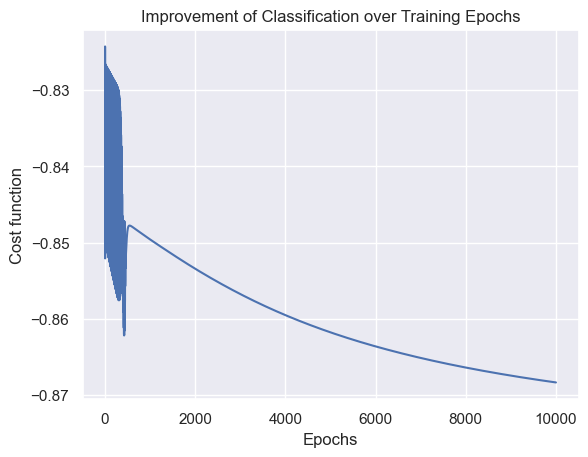

Average probability of correct predicted category 0.8683288850430274


In [4]:
# Train model
mdl = LogisticRegression()
mdl.alpha = 10 ** -4
errors = mdl.train(X_train, y_train, n_epoch=10000)

# Show model progression
plt.plot([err / n_sample for err in errors])
plt.title("Improvement of Classification over Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Cost function")
plt.show()
print("Average probability of correct predicted category", str(-errors[-1] / n_sample))

## Model performance
Let's see the model in action by plotting the sigmoid function against a scatterplot of the indicators.

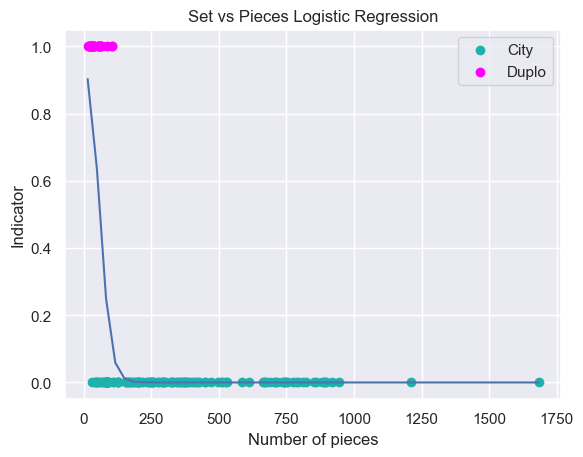

In [5]:
# Get x-domain for sigmoid
xdom = np.linspace(np.min(X_train), np.max(X_train)).reshape(-1, 1)

# Scatter City-theme sets
plt.scatter(X_train[df["Theme"] == "City"],
           np.zeros(np.sum(df["Theme"] == "City")),
           color="lightseagreen",
           label="City")

# Scatter Duplo-theme sets
plt.scatter(X_train[df["Theme"] == "Duplo"],
           np.ones(np.sum(df["Theme"] == "Duplo")),
           color="magenta",
           label="Duplo")

# Plot sigmoid
plt.plot(xdom, mdl.predict(xdom))

# Plot labels
plt.xlabel("Number of pieces")
plt.ylabel("Indicator")
plt.legend(loc = "upper right")
plt.title("Set vs Pieces Logistic Regression")
plt.show()

## Logistic regression on multiple dimensions
Hmm. Our logistic fit is not very good. It looks like the sigmoid is shifted very far left to the point where much of it is negative. This is becuase our Duplo sets have very few peices. Furthermore, the Duplo and City sets are not very separable; that is, there is significant overlap between the number of pieces in the Duplo and City sets.

Luckily, we can improve our fit by adding a second variable. Let's see what happens if we add the weight of the set as a second input variable.

Cost: -150.95719: 100%|██████████| 20000/20000 [01:58<00:00, 168.72it/s]


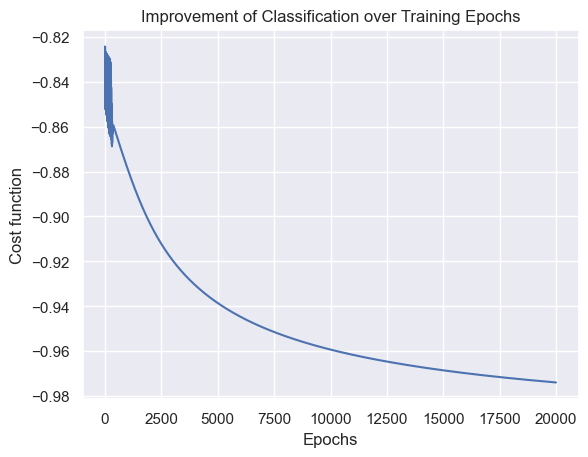

Average probability of correct predicted category 0.9739173491760601


In [6]:
# Add weight as a second input variable
X_train = df.filter(["Pieces", "Weight"]).values.reshape(-1, 2)

# Train new model 
mdl = LogisticRegression()
mdl.alpha = 10 ** -4
errors = mdl.train(X_train, y_train, n_epoch=20000)

# Show model progression
plt.plot([err / n_sample for err in errors])
plt.title("Improvement of Classification over Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Cost function")
plt.show()
print("Average probability of correct predicted category", str(-errors[-1] / n_sample))

### Model performance
Let's see if our two-variable model performs any better than our one-variable model by plotting a 3D sigmoid function.

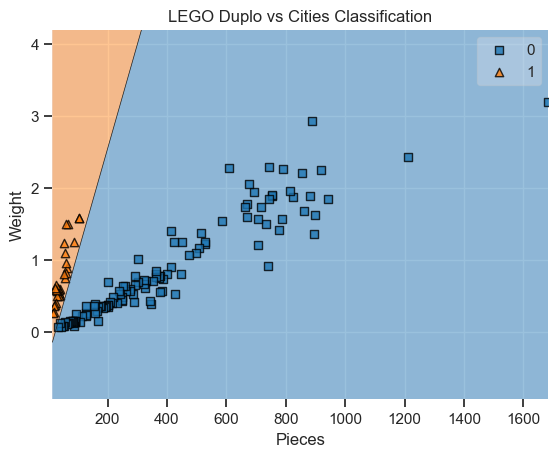

Text(0.5, 0, 'Indicator')

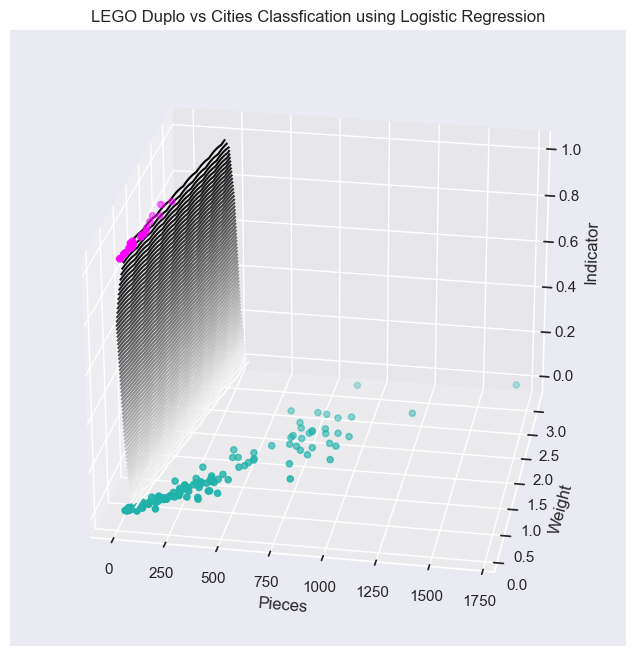

In [9]:
# Plot decision boundaries
plot_decision_regions(X_train, y_train.reshape((-1,)), clf=mdl)
plt.title("LEGO Duplo vs Cities Classification")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

# 3D logistic plot

# Create mesh of xy coordinates
xflat = np.linspace(np.min(X_train[:, 0]), np.max(X_train[:, 0]), 70) # x range
yflat = np.linspace(np.min(X_train[:, 1]), np.max(X_train[:, 1]), 70) # y range
xmesh, ymesh = np.meshgrid(xflat, yflat) # xy mesh

# Compute f(x,y) across xy mesh
xyflat = np.append(np.ndarray.flatten(xmesh).reshape(-1, 1), np.ndarray.flatten(ymesh).reshape(-1, 1), axis=1)
zflat = mdl.predict(xyflat)
zmesh = zflat.reshape((70, 70))

# Plot results of gradient descent
fig = plt.figure(figsize = (10, 8))
ax = plt.axes(projection='3d')
ax.contour3D(xmesh, ymesh, zmesh, 70, cmap='binary')
ax.scatter3D(X_train[duplo_ind, 0], X_train[duplo_ind, 1], y_train[duplo_ind], c="magenta")
ax.scatter3D(X_train[city_ind, 0], X_train[city_ind, 1], y_train[city_ind], c="lightseagreen")
ax.view_init(25, 280)
ax.set_title("LEGO Duplo vs Cities Classfication using Logistic Regression")
ax.set_xlabel('Pieces')
ax.set_ylabel('Weight')
ax.set_zlabel('Indicator')

The logistic regression classifier using both the pieces and weights as input variables performs substantially better. Examining the decision boundary, we see that the neuron correctly identifies the LEGO set theme almost every time. Notice this decision boundary is very similar to the one found by the Perceptron in `Perceptron.ipynb`, although the Perceptron converged on this decision boundary in far fewer epochs.

Plotting the 3D sigmoid function on a 3D scatterplot shows that the sigmoid slopes sharply at the decision boundary between the Duplo and City sets, providing for a decisive separation between the themes.